<a href="https://colab.research.google.com/github/Zach227/temp_files/blob/main/proj3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
%%bash
unzip data.zip

## Create Datasets

In [ ]:
import numpy as np
import random

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

In [ ]:
from custom_dataset import CustomImageDataset
from torch.utils.data import DataLoader
set_seed(11)

transform = transforms.Compose(
    [
        transforms.Resize((120, 120)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
batch_size = 2

data = CustomImageDataset(
    "data/train/train.csv", "data/train/", transform=transform
)

train_val_size = int(0.9 * len(data))
test_size = len(data) - train_val_size
train_size = int(0.9 * train_val_size)
val_size = train_val_size - train_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    data, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


classes = ["None", "glioma", "meningioma", "pituitary"]

Random seed set as 11


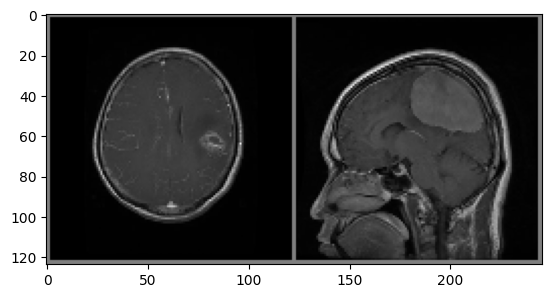

glioma meningioma
torch.Size([2, 3, 120, 120])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))
print(images.shape)

## Dummy Classifier

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="uniform")
train_labels = []

for images, labels in train_loader:
  for label in labels:
    train_labels.append(label)

dummy_classifier.fit(train_dataset, train_labels)

correct = 0
total = 0
set_seed(31)
for images, labels in val_loader:
    outputs = dummy_classifier.predict(images)
    for i in range(len(outputs)):
        if outputs[i] == labels[i]:
            correct += 1
        total += 1
print("Accuracy of the baseline model: %d %%" % (100 * correct / total))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Random seed set as 31
Accuracy of the baseline model: 24 %


## Define Networks



In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32 * 15 * 15, 64)
        self.fc2 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = x.view(-1, 32 * 15 * 15)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Additional convolutional layer
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))

        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))  # Extra fully connected layer
        x = self.fc3(x)

        return x


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class WiderCNN(nn.Module):
    def __init__(self):
        super(WiderCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 15 * 15, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = x.view(-1, 64 * 15 * 15)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## Initial Neural Network

In [ ]:
import torch.optim as optim

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=True)
set_seed(31)
model = CNN()
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)


for epoch in range(20):
  model.train()
  for i, data in enumerate(train_loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()


  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
      for data in val_loader:
          inputs, labels = data[0].to(device), data[1].to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  accuracy = correct / total
  print(f'Epoch:{epoch+1}: {1-accuracy}')

## Hyperparameter Sweep

In [ ]:


results_dict = {}
for batch_size in [2, 8]:
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
  for criterion in [nn.CrossEntropyLoss()]:
    for learning_rate in [0.001, 0.005]:
      for opt in ['SGD', 'Adam', 'RMSprop']:

        set_seed(31)
        model = CNN()
        # model = DeeperCNN()
        # model = WiderCNN()
        if opt == 'SGD':
          optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        elif opt == 'Adam':
          optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        elif opt == 'RMSprop':
          optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)


        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model.to(device)

        val_stats = []
        for epoch in range(20):
            model.train()
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()


            correct = 0
            total = 0
            model.eval()
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data[0].to(device), data[1].to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)  # returns max value, indices
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            accuracy = correct / total
            hyp_params = f'batch_size={batch_size}, criterion={criterion}, learning rate={learning_rate}, optimizer = {opt}, epochs = {epoch+1}'
            results_dict[hyp_params] = accuracy
            print(f'{hyp_params} ---> {1-accuracy}')

## Train Best Models

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
set_seed(31)
model1 = WiderCNN()
optimizer = optim.Adam(model1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model1.to(device)


for epoch in range(18):
  model1.train()
  for i, data in enumerate(train_loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      optimizer.zero_grad()

      outputs = model1(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()


  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
      for data in val_loader:
          inputs, labels = data[0].to(device), data[1].to(device)
          outputs = model1(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  accuracy = correct / total
  print(f'Epoch:{epoch+1}: {1-accuracy}')


PATH = f"./wide_adam_18.pth"
torch.save(model1.state_dict(), PATH)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
set_seed(31)
model2 = WiderCNN()
optimizer = optim.RMSprop(model2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model2.to(device)


for epoch in range(20):
  model.train()
  for i, data in enumerate(train_loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      optimizer.zero_grad()

      outputs = model2(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()


  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
      for data in val_loader:
          inputs, labels = data[0].to(device), data[1].to(device)
          outputs = model2(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  accuracy = correct / total
  print(f'Epoch:{epoch+1}: {1-accuracy}')


PATH = f"./wide_rms_20.pth"
torch.save(model2.state_dict(), PATH)

## Define Networks with Dropout

In [ ]:
class DropoutCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(DropoutCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32 * 15 * 15, 64)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = x.view(-1, 32 * 15 * 15)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
class DropoutDeeperCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(DropoutDeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Additional convolutional layer
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))

        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))  # Extra fully connected layer
        x = self.dropout(x)
        x = self.fc3(x)

        return x


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class DropoutWiderCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(DropoutWiderCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 15 * 15, 128)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = x.view(-1, 64 * 15 * 15)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

## Hyperparameter Sweep With Dropout

In [ ]:
import torch.optim as optim


for batch_size in [8, 2]:
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
  for criterion in [nn.CrossEntropyLoss()]:
    for learning_rate in [0.001]:
      for opt in ['Adam', 'RMSprop']:
        for dropout_rate in [0.6, 0.5, 0.6]:

          set_seed(31)
          model = DropoutWiderCNN(dropout_rate=dropout_rate)
          if opt == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
          elif opt == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
          elif opt == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)


          device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
          model.to(device)

          val_stats = []
          for epoch in range(30):
              model.train()
              for i, data in enumerate(train_loader, 0):
                  inputs, labels = data[0].to(device), data[1].to(device)

                  optimizer.zero_grad()
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)
                  loss.backward()
                  optimizer.step()

              correct = 0
              total = 0
              model.eval()
              with torch.no_grad():
                  for data in val_loader:
                      inputs, labels = data[0].to(device), data[1].to(device)
                      outputs = model(inputs)
                      _, predicted = torch.max(outputs.data, 1)  # returns max value, indices
                      total += labels.size(0)
                      correct += (predicted == labels).sum().item()
              accuracy = correct / total
              hyp_params = f'batch_size={batch_size}, learning rate={learning_rate}, optimizer={opt}, dropout_rate={dropout_rate}, epochs={epoch+1}'
              print(f'{hyp_params} ---> {1-accuracy}')

## Create Best Model

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
set_seed(31)
model3 = DropoutWiderCNN(dropout_rate=0.6)
optimizer = optim.Adam(model3.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model3.to(device)

val_stats = []
for epoch in range(26):
    model3.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    correct = 0
    total = 0
    model3.eval()
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model3(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Epoch:{epoch+1}: {1-accuracy}')


PATH = f"./wide_dropout_adam_26.pth"
torch.save(model3.state_dict(), PATH)

## Compare Final Models

In [ ]:
model1 = WiderCNN()
model2 = WiderCNN()
model3 = DropoutWiderCNN()
model1.load_state_dict(torch.load("wide_adam_18.pth"))
model2.load_state_dict(torch.load("wide_rms_20.pth"))
model3.load_state_dict(torch.load("wide_dropout_adam_26.pth"))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model1.to(device)
model2.to(device)
model3.to(device)

model1.eval()
model2.eval()
model3.eval()

In [ ]:
correct = 0
total = 0
set_seed(31)
for images, labels in test_loader:
    outputs = dummy_classifier.predict(images)
    for i in range(len(outputs)):
        if outputs[i] == labels[i]:
            correct += 1
        total += 1
print("Accuracy of the baseline model: %d %%" % (100 * correct / total))


correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy of Model 1 (No dropout, Adam optimizer): {(100 * correct / total):.2f} %")

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy of Model 2 (No dropout, RMSprop optimizer): {(100 * correct / total):.2f} %")

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model3(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy of model Model 3 (Dropout, Adam optimizer): {(100 * correct / total):.2f} %")




In [ ]:
correct_pred1 = {classname: 0 for classname in classes}
total_pred1 = {classname: 0 for classname in classes}
correct_pred2 = {classname: 0 for classname in classes}
total_pred2 = {classname: 0 for classname in classes}
correct_pred3 = {classname: 0 for classname in classes}
total_pred3 = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model1(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred1[classes[label]] += 1
            total_pred1[classes[label]] += 1

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model2(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred2[classes[label]] += 1
            total_pred2[classes[label]] += 1

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model3(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred3[classes[label]] += 1
            total_pred3[classes[label]] += 1

print("Model 1 Predictions by Class (No dropout, Adam optimizer)")
for classname, correct_count in correct_pred1.items():
    accuracy = 100 * float(correct_count) / total_pred1[classname]
    print(f"Accuracy for class: {classname} is {accuracy:.1f} %")

print("\nModel 2 Predictions by Class (No dropout, RMSprop optimizer)")
for classname, correct_count in correct_pred2.items():
    accuracy = 100 * float(correct_count) / total_pred2[classname]
    print(f"Accuracy for class: {classname} is {accuracy:.1f} %")

print("\nModel 3 Predictions by Class (Dropout, Adam optimizer)")
for classname, correct_count in correct_pred3.items():
    accuracy = 100 * float(correct_count) / total_pred3[classname]
    print(f"Accuracy for class: {classname} is {accuracy:.1f} %")

## Final Sweep

In [ ]:
import torch.optim as optim


for batch_size in [4, 8, 16]:
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
  for criterion in [nn.CrossEntropyLoss()]:
    for learning_rate in [0.001]:
      for opt in ['Adam', 'RMSprop']:
        for dropout_rate in [0.2, 0.4, 0.6, 0.8]:

          set_seed(31)
          model = DropoutWiderCNN(dropout_rate=dropout_rate)
          if opt == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
          elif opt == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
          elif opt == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)


          device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
          model.to(device)

          val_stats = []
          for epoch in range(40):
              model.train()
              for i, data in enumerate(train_loader, 0):
                  inputs, labels = data[0].to(device), data[1].to(device)

                  optimizer.zero_grad()
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)
                  loss.backward()
                  optimizer.step()

              correct = 0
              total = 0
              model.eval()
              with torch.no_grad():
                  for data in val_loader:
                      inputs, labels = data[0].to(device), data[1].to(device)
                      outputs = model(inputs)
                      _, predicted = torch.max(outputs.data, 1)  # returns max value, indices
                      total += labels.size(0)
                      correct += (predicted == labels).sum().item()
              accuracy = correct / total
              hyp_params = f'batch_size={batch_size}, learning rate={learning_rate}, optimizer={opt}, dropout_rate={dropout_rate}, epochs={epoch+1}'
              print(f'{hyp_params} ---> {1-accuracy}')

              if epoch == 39:
                PATH = f"./{hyp_params}.pth"
                torch.save(model3.state_dict(), PATH)